<img src="../dataset_research_paper_docs/transformer_archi.png" alt="transformer" width="600" style="display:block; margin:auto;">


# Char level


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

In [143]:
with open("../dataset_research_paper_docs/input_text.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [144]:
len(text)

1115393

In [145]:
print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [146]:
chars = set(text)
print(len(chars))
print(chars, sep="")

65
{'p', 'P', 'J', 'w', 'v', "'", '.', 'Y', 'l', ' ', 't', 'A', 'O', 'r', 'u', 'h', 'D', 'f', 'k', 'i', '-', 'q', '!', 'a', 's', 'X', 'B', 'o', 'n', '$', 'Z', 'z', 'b', 'F', 'I', 'H', 'x', '\n', 'c', 'y', 'V', 'N', 'G', 'm', 'K', 'g', 'j', 'W', 'E', ':', 'R', 'U', 'S', 'Q', '&', '3', ';', ',', 'L', 'M', '?', 'd', 'e', 'T', 'C'}


In [147]:
chars = list(set(text))
chars[:10]

['p', 'P', 'J', 'w', 'v', "'", '.', 'Y', 'l', ' ']

---


In [148]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


## `create` a mapping table for string to integer


In [149]:
strtoint = {ch: i for i, ch in enumerate(chars)}
inttostr = {i: ch for i, ch in enumerate(chars)}

encode_txt = lambda s: [strtoint[c] for c in s]
# returns list of integer for input string given

decode_txt = lambda l: "".join(inttostr[i] for i in l)
# returns string from given integers

In [150]:
list(strtoint.items())[:10]  # lookuptable

[('\n', 0),
 (' ', 1),
 ('!', 2),
 ('$', 3),
 ('&', 4),
 ("'", 5),
 (',', 6),
 ('-', 7),
 ('.', 8),
 ('3', 9)]

In [151]:
list(strtoint.items())[-10:]  # lookuptable

[('q', 55),
 ('r', 56),
 ('s', 57),
 ('t', 58),
 ('u', 59),
 ('v', 60),
 ('w', 61),
 ('x', 62),
 ('y', 63),
 ('z', 64)]

In [152]:
list(inttostr.items())[-10:]  # lookuptable

[(55, 'q'),
 (56, 'r'),
 (57, 's'),
 (58, 't'),
 (59, 'u'),
 (60, 'v'),
 (61, 'w'),
 (62, 'x'),
 (63, 'y'),
 (64, 'z')]

---


Character level token


In [153]:
encode_txt("what zxy moountain ")

[61, 46, 39, 58, 1, 64, 62, 63, 1, 51, 53, 53, 59, 52, 58, 39, 47, 52, 1]

In [154]:
decode_txt([61, 46, 39, 58, 1, 64, 62, 63, 1, 51, 53, 53, 59, 52, 58, 39, 47, 52, 1])

'what zxy moountain '

In [155]:
print(encode_txt("hello people"))

enc_text = encode_txt("hello people")

print(decode_txt(enc_text))

[46, 43, 50, 50, 53, 1, 54, 43, 53, 54, 50, 43]
hello people


# Google uses [sentencepiece](https://github.com/google/sentencepiece) for tokenization.

SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.


# OpenAI uses Byte Pair Encoding [BPE](https://github.com/openai/tiktoken) for tokenization.

BPE is a simple form of data compression that iteratively replaces the most frequent pair of bytes in a sequence with a single, unused byte. In the context of tokenization, BPE is used to create a vocabulary of subword units that can efficiently represent text data. The algorithm starts with a base vocabulary of individual characters and then merges the most frequent pairs of characters or subwords to form new tokens. This process continues until a predefined vocabulary size is reached. BPE is particularly effective for handling out-of-vocabulary words and capturing common patterns in text, making it a popular choice for tokenization in natural language processing tasks.


In [156]:
# !pip install tiktoken

In [157]:
import tiktoken

In [158]:
enc = tiktoken.get_encoding("gpt2")

In [159]:
print(enc.encode("Hi everyone"))
that = enc.encode("Hi everyone")
enc.decode(that)

[17250, 2506]


'Hi everyone'

---


`Encode` the whole shakespeare text


In [160]:
text[:50]

'First Citizen:\nBefore we proceed any further, hear'

In [161]:
# encode whole text
data = torch.tensor(encode_txt(text), dtype=torch.long)
print(data.shape, data.dtype)
# print first 500 character encoding
print(data[:500])

torch.Size([1115393]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

# `split` the data to train test


In [162]:
print(data.shape)

torch.Size([1115393])


In [163]:
n = int(0.9 * len(data))
print(n)


# first 90% in the train and rest 10% in the val


train_data = data[:n]
val_data = data[n:]

1003853


while training we dont give the model the full sequence rather we give part of the sequence and do it in batches.


block size or context length : how many tokens the model can see at a time


In [164]:
block_size = 8
train_data[: block_size + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [165]:
print(
    "given ->",
    train_data[:block_size],
    "predict ->",
    train_data[block_size],
    "total ->",
    train_data[: block_size + 1],
)

given -> tensor([18, 47, 56, 57, 58,  1, 15, 47]) predict -> tensor(58) total -> tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])


In [166]:
# x is the input to the transformer --first block size characters
# y is offset by 1 to x ----- next block size character. - y is the target for each position to the input

x = train_data[:block_size]
y = train_data[1 : block_size + 1]

for t in range(block_size):
    context = x[: t + 1]
    target = y[t]
    print("when input is ", context, "o/p ---> ", target)

when input is  tensor([18]) o/p --->  tensor(47)
when input is  tensor([18, 47]) o/p --->  tensor(56)
when input is  tensor([18, 47, 56]) o/p --->  tensor(57)
when input is  tensor([18, 47, 56, 57]) o/p --->  tensor(58)
when input is  tensor([18, 47, 56, 57, 58]) o/p --->  tensor(1)
when input is  tensor([18, 47, 56, 57, 58,  1]) o/p --->  tensor(15)
when input is  tensor([18, 47, 56, 57, 58,  1, 15]) o/p --->  tensor(47)
when input is  tensor([18, 47, 56, 57, 58,  1, 15, 47]) o/p --->  tensor(58)


there is a new dimension batch dimension
while training we dont give the model the full sequence rather we give part of the sequence and do it in batches.

batches of sequences of block size length are fed for efficiency to process in parallel

batch of sequence of block size length are stacked in tensor and fed to process


In [167]:
block_size = 8  # length of the input sequence
batch_size = 4  # no of input sequence to process in parallel

In [168]:
len(data) - block_size

1115385

In [169]:
len(train_data) - block_size

1003845

In [170]:
# four independent rows


ix = torch.randint(len(data) - block_size, (batch_size,))
ix

tensor([279418, 386416,  68800, 755839])

In [171]:
print(ix[0])
data[ix[0].item()]

tensor(279418)


tensor(52)

in a batch,completely independent sequences are selected randomly of block size


In [172]:
x = torch.stack([data[i : i + block_size] for i in ix])
y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
print(x)
print(y)

tensor([[52, 57,  1, 57, 51, 53, 58, 46],
        [ 1, 44, 47, 45, 46, 58, 10,  0],
        [58,  1, 52, 53, 58,  1, 39,  1],
        [ 8,  0, 32, 46, 39, 58,  1, 21]])
tensor([[57,  1, 57, 51, 53, 58, 46, 43],
        [44, 47, 45, 46, 58, 10,  0, 13],
        [ 1, 52, 53, 58,  1, 39,  1, 54],
        [ 0, 32, 46, 39, 58,  1, 21,  1]])


In [173]:
print(x.shape, y.shape)

torch.Size([4, 8]) torch.Size([4, 8])


- when generating block size of context length(block size continuous adjacent data) ,subtract len(data)-block size to avoid out of index
- ie block size needed is 8 and if data length is 100 and block size is 8 ,the max starting point can be 92 to get 92 to 100 (8 length)


In [ ]:
block_size = 8  # length of the input sequence
batch_size = 4  # no of input sequence to process in parallel

torch.manual_seed(42)


def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    return x, y


xb, yb = get_batch("train")
print("inputs: ", xb.shape)
print(xb)
print("----\n ")
print("targets: ", yb.shape)
print(yb)

# xb is the input to the transformer

# for 54 target is 43,for 43 target is 39 for single token target

inputs:  torch.Size([4, 8])
tensor([[54, 43, 39, 49,  1, 39, 45, 39],
        [43, 56, 57, 11,  1, 61, 46, 53],
        [43,  1, 46, 39, 58, 46,  1, 58],
        [43,  1, 47, 57,  1, 57, 53,  1]])
----
 
targets:  torch.Size([4, 8])
tensor([[43, 39, 49,  1, 39, 45, 39, 47],
        [56, 57, 11,  1, 61, 46, 53,  6],
        [ 1, 46, 39, 58, 46,  1, 58, 56],
        [ 1, 47, 57,  1, 57, 53,  1, 50]])


In [175]:
print(batch_size, block_size)

4 8


In [176]:
for i in range(batch_size):
    for j in range(block_size):
        context = xb[i, : j + 1]
        target = yb[i, j]
        print("when input is ", context.tolist(), "output --> ", target)

when input is  [54] output -->  tensor(43)
when input is  [54, 43] output -->  tensor(39)
when input is  [54, 43, 39] output -->  tensor(49)
when input is  [54, 43, 39, 49] output -->  tensor(1)
when input is  [54, 43, 39, 49, 1] output -->  tensor(39)
when input is  [54, 43, 39, 49, 1, 39] output -->  tensor(45)
when input is  [54, 43, 39, 49, 1, 39, 45] output -->  tensor(39)
when input is  [54, 43, 39, 49, 1, 39, 45, 39] output -->  tensor(47)
when input is  [43] output -->  tensor(56)
when input is  [43, 56] output -->  tensor(57)
when input is  [43, 56, 57] output -->  tensor(11)
when input is  [43, 56, 57, 11] output -->  tensor(1)
when input is  [43, 56, 57, 11, 1] output -->  tensor(61)
when input is  [43, 56, 57, 11, 1, 61] output -->  tensor(46)
when input is  [43, 56, 57, 11, 1, 61, 46] output -->  tensor(53)
when input is  [43, 56, 57, 11, 1, 61, 46, 53] output -->  tensor(6)
when input is  [43] output -->  tensor(1)
when input is  [43, 1] output -->  tensor(46)
when input 

---


## start feeding to NN

- Bigram model
  - simple model for language modeling that predicts the next token based on the current token using a lookup table.
  - each token in the vocabulary has a corresponding embedding vector in the lookup table.


In [177]:
# table of size (vocab_size, vocab_size) where each row corresponds to a token in the vocabulary and contains the logits for predicting the next token.

# here each token is made to (65\*65)

# Embedding =  matrix of shape (num_embeddings, embedding_dim)

# when
# logits = self.token_embedding_table(idx)
# internally
# logits[b, t] = W[idx[b, t]]

# The embedding table is formed by initializing a (vocab_size × vocab_size) matrix with random values and then gradually shaping each row through gradient descent so that it learns the logits for predicting the next token given the current token.

In [178]:
torch.manual_seed(1337)


class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)  # 65*65

    def forward(self, idx, targets):
        # idx and target are both (B,T)tensor of integer B-batch ,T-time/block_size/context length, C-channel. (here b=4,T=8,C=vocabsize ie 65)

        logits = self.token_embedding_table(idx)
        return logits


m = BigramLanguageModel(vocab_size)
out = m(xb, yb)
print(out.shape)

# idx or xb =(4,8)
# returned logits= (4,8,65)(4batch of 8dim with 65vec)

torch.Size([4, 8, 65])


In [179]:
xb.shape

torch.Size([4, 8])

In [180]:
x[1]

tensor([ 1, 44, 47, 45, 46, 58, 10,  0])

#returned logits= (4,8,65)(4batch of 65dim vector for each of the 8 tokens in the sequence)

- Each integer in the 8-length vector becomes a 65-length vector
- for x[4,8] 4 vec of 8dimlength each logits returns as (4,8,65) ,4batch of 65dim vector for each of the 8 tokens in the sequence
- [ 0, 32, 46, 53, 59, 1, 40, 43] each integer in 8-length vector becomes a 65-length vector


In [181]:
out[:1].shape

torch.Size([1, 8, 65])

In [182]:
out[:1]

tensor([[[-6.7874e-01,  8.6619e-01, -1.6433e+00,  1.9448e+00, -1.6309e-01,
          -1.7145e-01,  9.3094e-01, -8.5501e-01,  7.5243e-01,  2.6255e-01,
          -1.3360e+00, -9.7573e-01, -5.1340e-01,  7.1156e-01, -1.9585e-02,
           4.3529e-01,  8.2789e-01,  5.4866e-01, -4.3626e-01,  5.5188e-01,
           6.7815e-01,  2.5347e-01,  1.6661e+00, -6.9642e-01, -3.1699e-01,
           8.4865e-01,  4.3408e-01, -2.2396e-01, -1.0157e+00, -1.1612e-01,
           2.8764e-01,  4.2026e-01,  3.3789e-01,  8.0157e-01, -1.7313e-01,
           5.8086e-01,  1.6225e-01,  1.3970e+00,  3.3073e-01,  2.7711e-01,
           7.4096e-01,  2.7270e-01,  2.3462e-01, -1.1172e-01, -5.6908e-01,
           1.1829e+00,  1.9441e+00, -4.1552e-01, -3.6204e-01, -1.7652e-01,
          -9.3482e-01,  1.5461e+00, -8.5770e-01, -1.0060e-01,  3.5597e-01,
          -1.6589e+00,  6.5434e-01, -1.3299e+00,  1.1929e+00,  4.8549e-01,
          -5.7211e-01,  1.0813e+00,  2.3671e+00, -7.7751e-01, -2.5861e-01],
         [ 3.3227e-01, -

In [183]:
torch.manual_seed(1337)


class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)  # 65*65

    def forward(self, idx, targets):
        # idx and target are both (B,T)tensor of integer B-batch ,T-time/block_size/context length, C-channel. (here b=4,T=8,C=vocabsize ie 65)

        logits = self.token_embedding_table(idx)  # (B,T,C)ie(4,8,65)
        B, T, C = logits.shape
        logits = logits.view(B * T, C)  # (32*65) stretching the vec

        targets = targets.view(B * T)  # (32)
        loss = F.cross_entropy(logits, targets)

        return logits, loss


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print("logits", logits.shape, "\n loss= ", loss)

# idx or xb =(4,8)
# returned logits= (4*8,65) stretched vec
# losscalculation
# The 65-logit vector represents a distribution over choices.
# The target integer selects the correct choice, and the loss measures how much probability the model assigned to that choice.

logits torch.Size([32, 65]) 
 loss=  tensor(4.7691, grad_fn=<NllLossBackward0>)


In [184]:
print(logits)

tensor([[-0.6787,  0.8662, -1.6433,  ...,  2.3671, -0.7775, -0.2586],
        [ 0.3323, -0.0872, -0.7470,  ..., -0.6716, -0.9572, -0.9594],
        [ 1.1513,  1.0539,  3.4105,  ..., -0.5686,  0.9079, -0.1701],
        ...,
        [-0.5201,  0.2831,  1.0847,  ..., -0.0198,  0.7959,  1.6014],
        [-0.1324, -0.5489,  0.1024,  ..., -0.8599, -1.6050, -0.6985],
        [ 0.5978, -0.0514, -0.0646,  ..., -1.4649, -2.0555,  1.8275]],
       grad_fn=<ViewBackward0>)


In [185]:
logits.shape

torch.Size([32, 65])

In [186]:
B, T = 4, 8
print(yb.view(B * T))
yb.view(B * T).shape

tensor([43, 39, 49,  1, 39, 45, 39, 47, 56, 57, 11,  1, 61, 46, 53,  6,  1, 46,
        39, 58, 46,  1, 58, 56,  1, 47, 57,  1, 57, 53,  1, 50])


torch.Size([32])

loss calculation complete


---


# Generate text


1. Part 1 dimension calculation for single step of generation and explanation
2. Part 2 implementation


# Part 1


for a single tensor sent to predict next token


In [187]:
# for single next token calculation ,max_new_tokens=1

torch.manual_seed(1337)


class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)  # 65*65

    def forward(self, idx, targets=None):
        # idx and target are both (B,T)tensor of integer B-batch ,T-time/block_size/context length, C-channel. (here b=4,T=8,C=vocabsize ie 65)

        logits = self.token_embedding_table(idx)  # logits becomes (B,T,C)ie(4,8,65)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)  # (32*65) stretching the vec
            targets = targets.view(B * T)  # (32)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # takes (B,T) and generate work is to generate (b,T+1,T+2)ie generate new token in time dim ie(contextlength dim)
        # idx is (B,T) array of indices in the current context(1,1)
        for _ in range(max_new_tokens):
            #   get new prediction
            logits, loss = self(idx)
            # returns(batch, time, embedding_dim) ie(B,T,C)->(1,1)->(1,1,65)
            # during iteration when idx increases egidx=[31,32] logits, loss = self(idx) returns (1,2,65)
            # then logits = logits[:, -1, :]  selects last element of timedim so results(1,65)batch,vocab/contextdim
            print("---\n")
            print("logit_shape_prev", logits.shape)
            print("logits_prev=", logits)
            # focus only on the last time step
            logits = logits[
                :, -1, :
            ]  # becomes (B,C) <-last element in the time dim,,,just one time dim so selects that whole tensor(1,1)->(1,1,65)->(1,65)
            # applying softmax to get probabilities form logits
            print("---\n")
            print("logits_next=", logits)
            print("logit_shape_next", logits.shape)
            probs = F.softmax(logits, dim=-1)  # (B,C)
            print("---\n")
            print("probs=", probs)
            print("probsshape", probs.shape)  # (1,65)
            # sample from the distribution
            idx_next = torch.multinomial(
                probs, num_samples=1
            )  # (B,1)ie(1,1)selects any one token from the probability values from 65 of them
            #   append sampled index to the running sequence
            # Selects the next token based on the probability of each token, so higher-probability tokens are more likely but not guaranteed.
            print("---\n")
            print("idx_next=", idx_next)
            print("idx_nextshape", idx_next.shape)
            idx = torch.cat((idx, idx_next), dim=1)  # (B,T+1)
            # eg idx=[31,32]
        return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print("logits", logits.shape, "\n loss= ", loss)


# --------
# generate
idx = torch.zeros((1, 1), dtype=torch.long)
# PyTorch expects a batch dimension in tensors, so even a single sequence must be shaped as (B, T) rather than just (T).
print("idx begin------")
print("idx=", idx)
print("idxshape", idx.shape)
ret_idx = m.generate(idx, max_new_tokens=1)[0].tolist()
print("ret_idx=", ret_idx)
print("len=", len(ret_idx))
print("generated_text", decode_txt(ret_idx))

logits torch.Size([32, 65]) 
 loss=  tensor(4.7691, grad_fn=<NllLossBackward0>)
idx begin------
idx= tensor([[0]])
idxshape torch.Size([1, 1])
---

logit_shape_prev torch.Size([1, 1, 65])
logits_prev= tensor([[[ 0.1808, -0.0700, -0.3596, -0.9152,  0.6258,  0.0255,  0.9545,
           0.0643,  0.3612,  1.1679, -1.3499, -0.5102,  0.2360, -0.2398,
          -0.9211,  1.5433,  1.3488, -0.1396,  0.2858,  0.9651, -2.0371,
           0.4931,  1.4870,  0.5910,  0.1260, -1.5627, -1.1601, -0.3348,
           0.4478, -0.8016,  1.5236,  2.5086, -0.6631, -0.2513,  1.0101,
           0.1215,  0.1584,  1.1340, -1.1539, -0.2984, -0.5075, -0.9239,
           0.5467, -1.4948, -1.2057,  0.5718, -0.5974, -0.6937,  1.6455,
          -0.8030,  1.3514, -0.2759, -1.5108,  2.1048,  2.7630, -1.7465,
           1.4516, -1.5103,  0.8212, -0.2115,  0.7789,  1.5333,  1.6097,
          -0.4032, -0.8345]]], grad_fn=<EmbeddingBackward0>)
---

logits_next= tensor([[ 0.1808, -0.0700, -0.3596, -0.9152,  0.6258,  0.0255, 

In [188]:
# generatedtext must be \nS. char 1 by one \n is treated ans new line here in output

In [189]:
list(strtoint.items())[:5]  # lookuptable

[('\n', 0), (' ', 1), ('!', 2), ('$', 3), ('&', 4)]

In [190]:
torch.zeros((1, 1), dtype=torch.long).item()

0

In [191]:
decode_txt([torch.zeros((1), dtype=torch.long).item()])

'\n'

In [192]:
decode_txt([31])

'S'

In [193]:
# for max_new_tokens=3

torch.manual_seed(1337)


class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)  # 65*65

    def forward(self, idx, targets=None):
        # idx and target are both (B,T)tensor of integer B-batch ,T-time/block_size/context length, C-channel. (here b=4,T=8,C=vocabsize ie 65)

        logits = self.token_embedding_table(idx)  # logits becomes (B,T,C)ie(4,8,65)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)  # (32*65) stretching the vec
            targets = targets.view(B * T)  # (32)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # takes (B,T) and generate work is to generate (b,T+1,T+2)ie generate new token in time dim ie(contextlength dim)
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            print("******" * 8, "\ntoken no= ", _ + 1)
            #   get new predication
            logits, loss = self(idx)
            # focus only on the last time step
            print("---\n")
            print("logit_shape_prev", logits.shape)
            print("logits_prev=", logits)
            logits = logits[:, -1, :]  # becomes (B,C) <-last element in the time dim
            # applying softmax to get probabilities form logits
            print("---\n")
            print("logits_next=", logits)
            print("logit_shape_next", logits.shape)
            probs = F.softmax(logits, dim=-1)  # (B,C)
            print("---\n")
            print("probs=", probs)
            print("probsshape", probs.shape)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B,1)
            #   append sampled index to the running sequence
            print("---\n")
            print("idx_next=", idx_next)
            print("idx_nextshape", idx_next.shape)
            idx = torch.cat((idx, idx_next), dim=1)  # (B,T+1)
        return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print("logits", logits.shape, "\n loss= ", loss)

# --------
# generate
idx = torch.tensor([[31]], dtype=torch.long)
print("idx=", idx)
print("idxshape", idx.shape)
ret_idx = m.generate((idx), max_new_tokens=3)[0].tolist()
print("ret_idx=", ret_idx)
print("len=", len(ret_idx))
print("generated_text", decode_txt(ret_idx))

logits torch.Size([32, 65]) 
 loss=  tensor(4.7691, grad_fn=<NllLossBackward0>)
idx= tensor([[31]])
idxshape torch.Size([1, 1])
************************************************ 
token no=  1
---

logit_shape_prev torch.Size([1, 1, 65])
logits_prev= tensor([[[-1.0699, -0.6119, -0.4034,  0.3025,  0.6852, -1.0045, -1.0104,
          -1.0886,  1.3292,  0.5912, -1.1082, -1.2869, -0.8170,  0.9682,
           1.6030, -0.0726, -0.4725, -1.1616,  0.5962,  1.3058, -0.7422,
          -1.2529,  0.6750,  1.5664, -0.9238, -0.0956, -1.5452, -0.1801,
           3.1838, -0.1277,  0.0910,  0.5422, -0.6110,  0.5220,  2.1368,
          -1.4166, -0.8557,  1.0129,  0.6503,  0.2432,  1.2588, -0.0644,
          -0.9707, -0.4880, -0.2550, -0.4089, -0.7687,  1.0953,  1.5294,
          -1.2395,  1.0547,  0.5108,  0.3854, -0.8898,  1.3468,  2.3590,
           0.1071, -1.2616,  0.7945, -0.7739, -0.1497, -0.6214,  1.0078,
           0.2930,  0.0943]]], grad_fn=<EmbeddingBackward0>)
---

logits_next= tensor([[-1.069

In [194]:
torch.tensor([[31]], dtype=torch.long)

tensor([[31]])

In [195]:
torch.zeros((1, 1), dtype=torch.long)

tensor([[0]])

---


# Part 2


In [ ]:
# max_new_tokens=100

torch.manual_seed(1337)


class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)  # 65*65

    def forward(self, idx, targets=None):
        # idx and target are both (B,T)tensor of integer B-batch ,T-time/block_size/context length, C-channel. (here b=4,T=8,C=vocabsize ie 65)

        logits = self.token_embedding_table(idx)  # logits becomes (B,T,C)ie(4,8,65)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)  # (32*65) stretching the vec
            targets = targets.view(B * T)  # (32)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # takes (B,T) and generate work is to generate (b,T+1,T+2)ie generate new token in time dim ie(contextlength dim)
        # idx is (B,T) array of indices in the current context(1,1)
        for _ in range(max_new_tokens):
            #   get new prediction
            logits, loss = self(idx)
            # returns(batch, time, embedding_dim) ie(B,T,C)->(1,1)->(1,1,65)
            # focus only on the last time step
            logits = logits[
                :, -1, :
            ]  # becomes (B,C) <-last element in the time dim,,,just one time dim so selects that whole tensor(1,1)->(1,1,65)->(1,65)
            # applying softmax to get probabilities form logits
            probs = F.softmax(logits, dim=-1)  # (B,C)
            # sample from the distribution
            idx_next = torch.multinomial(
                probs, num_samples=1
            )  # (B,1)ie(1,1)selects any one token from the probability values from 65 of them
            idx = torch.cat((idx, idx_next), dim=1)  # (B,T+1)
            # eg next = idx=[31,32]
        return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print("logits", logits.shape, "\n loss= ", loss)


# --------
# generate
idx = torch.zeros((1, 1), dtype=torch.long)
# 0 index in vocab represents \n
# PyTorch expects a batch dimension in tensors, so even a single sequence must be shaped as (B, T) rather than just (T).
print("idx begin------")
print("idx=", idx)
print("idxshape", idx.shape)
ret_idx = m.generate(idx, max_new_tokens=100)[0].tolist()
print("ret_idx=", ret_idx)
print("len=", len(ret_idx))
print("----\n generated_text -> ", decode_txt(ret_idx))
# print(m.generate(torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist())

logits torch.Size([32, 65]) 
 loss=  tensor(4.7691, grad_fn=<NllLossBackward0>)
idx begin------
idx= tensor([[0]])
idxshape torch.Size([1, 1])
ret_idx= [0, 31, 23, 21, 41, 24, 32, 11, 13, 41, 17, 24, 25, 53, 32, 40, 60, 38, 60, 1, 15, 12, 52, 55, 7, 29, 17, 9, 9, 10, 15, 22, 55, 49, 27, 23, 20, 7, 55, 11, 10, 50, 39, 2, 53, 47, 63, 61, 49, 20, 48, 45, 15, 46, 64, 40, 29, 12, 59, 2, 9, 40, 24, 21, 45, 61, 43, 60, 51, 63, 18, 22, 19, 33, 19, 54, 0, 61, 52, 37, 35, 51, 52, 62, 23, 35, 35, 43, 60, 7, 58, 16, 55, 36, 17, 56, 34, 23, 24, 45, 22]
len= 101
----
 generated_text ->  
SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [ ]:
print(
    decode_txt(
        m.generate(torch.zeros((1, 1), dtype=torch.long), max_new_tokens=600)[
            0
        ].tolist()
    )
)

result is sort of garbage because next token is predicted only on the basis of current token without any context of previous tokens.
for prediction of T SKIcLT model only sees L and predicts next token T ,without any context of previous tokens SKIc.

- next task is to make model see previous tokens as context not just the current token while predicting next token.

---


In [197]:
# lets improve model

In [198]:
# create a Pytorch optimizer

optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)

In [ ]:
# training loop

batch_size = 32  # previously 4
lossitm = []
for steps in range(20000):
    # sample a batch of data
    xb, yb = get_batch("train")

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    lossitm.append(loss.item())

In [204]:
lossitm[-10:]

[2.4557886123657227,
 2.3607707023620605,
 2.4638681411743164,
 2.3458073139190674,
 2.456632375717163,
 2.352128028869629,
 2.5676419734954834,
 2.427316427230835,
 2.47452449798584,
 2.5497617721557617]

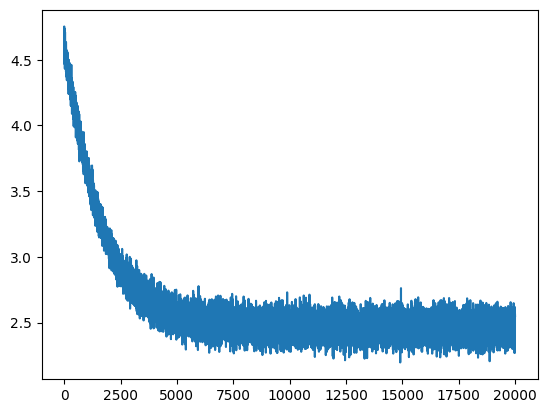

In [207]:
import matplotlib.pyplot as plt

plt.plot(lossitm)

In [ ]:
print(
    decode_txt(
        m.generate(torch.zeros((1, 1), dtype=torch.long), max_new_tokens=600)[
            0
        ].tolist()
    )
)


OUpld thoof n lot. nde.

Lou onduss femyour ecealithinsthif twifre:

JUCHis s, my wecredous mpl; d an hen h Whechy ls ait osibust h, th ce pre aloods MABread ite.
KESThe t
ws.
thug t whr, wod,
I iso
Sibe BRDougit owe wampous ourewe u dous o nd'ly, i'sourlofilay, tat mefootope k hthe.
Thl woug,

To swounat mbat apol gankier; uld he ass clyounereaishin ceyof isous, ol

ifense fard, diforataris nnigur peald praw aneweiveathave:
I wad? Mat, puld st s s mease a mame it nnco sem. ho elesess bar IO,
DUSo?
Gour banindo s, hes m'drl, towe ds, th that HED nshe ckind m ne n rithar mburderge dsth br,
Hido


In [ ]:
# slight improvement in the model

# Self Attention

Self-attention is a mechanism that allows a model to weigh the importance of different tokens in a sequence when making predictions. In the context of language modeling, self-attention enables the model to consider the relationships between words in a sentence, allowing it to capture context and dependencies more effectively.


- for the current token to attend to previous tokens, we need to mask the future tokens.
- for the current token ,lets average the embeddings of all previous tokens and use that to predict the next token.


# Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

```
B,T,C=4,8,2
x=torch.randn(B,T,C)
x.shape

# we want x[b,t]=mean_{i<=t} x[b,i]

xbow=torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev=x[b,:t+1] #t,c
        print(xprev)
        xbow[b,t]=torch.mean(xprev,0)
```

xbow represents the averaged embeddings of all previous tokens for each token in the sequence.


In [ ]:
# eg

torch.manual_seed(1337)

B, T, C = 4, 8, 2
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [11]:
x

tensor([[[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]],

        [[ 1.3488, -0.1396],
         [ 0.2858,  0.9651],
         [-2.0371,  0.4931],
         [ 1.4870,  0.5910],
         [ 0.1260, -1.5627],
         [-1.1601, -0.3348],
         [ 0.4478, -0.8016],
         [ 1.5236,  2.5086]],

        [[-0.6631, -0.2513],
         [ 1.0101,  0.1215],
         [ 0.1584,  1.1340],
         [-1.1539, -0.2984],
         [-0.5075, -0.9239],
         [ 0.5467, -1.4948],
         [-1.2057,  0.5718],
         [-0.5974, -0.6937]],

        [[ 1.6455, -0.8030],
         [ 1.3514, -0.2759],
         [-1.5108,  2.1048],
         [ 2.7630, -1.7465],
         [ 1.4516, -1.5103],
         [ 0.8212, -0.2115],
         [ 0.7789,  1.5333],
         [ 1.6097, -0.4032]]])

In [ ]:
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)
x.shape

# we want x[b,t]=mean_{i<=t} x[b,i]

xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, : t + 1]  # t,c
        print(xprev)
        xbow[b, t] = torch.mean(xprev, 0)

tensor([[-0.8345,  0.5978]])
tensor([[-0.8345,  0.5978],
        [-0.0514, -0.0646]])
tensor([[-0.8345,  0.5978],
        [-0.0514, -0.0646],
        [-0.4970,  0.4658]])
tensor([[-0.8345,  0.5978],
        [-0.0514, -0.0646],
        [-0.4970,  0.4658],
        [-0.2573, -1.0673]])
tensor([[-0.8345,  0.5978],
        [-0.0514, -0.0646],
        [-0.4970,  0.4658],
        [-0.2573, -1.0673],
        [ 2.0089, -0.5370]])
tensor([[-0.8345,  0.5978],
        [-0.0514, -0.0646],
        [-0.4970,  0.4658],
        [-0.2573, -1.0673],
        [ 2.0089, -0.5370],
        [ 0.2228,  0.6971]])
tensor([[-0.8345,  0.5978],
        [-0.0514, -0.0646],
        [-0.4970,  0.4658],
        [-0.2573, -1.0673],
        [ 2.0089, -0.5370],
        [ 0.2228,  0.6971],
        [-1.4267,  0.9059]])
tensor([[-0.8345,  0.5978],
        [-0.0514, -0.0646],
        [-0.4970,  0.4658],
        [-0.2573, -1.0673],
        [ 2.0089, -0.5370],
        [ 0.2228,  0.6971],
        [-1.4267,  0.9059],
        [ 0.1

In [ ]:
np.mean(np.array([0.1808, -0.3596]))

np.float64(-0.0894)

In [14]:
x[0]

tensor([[-0.8345,  0.5978],
        [-0.0514, -0.0646],
        [-0.4970,  0.4658],
        [-0.2573, -1.0673],
        [ 2.0089, -0.5370],
        [ 0.2228,  0.6971],
        [-1.4267,  0.9059],
        [ 0.1446,  0.2280]])

In [15]:
xbow[0]

tensor([[-0.8345,  0.5978],
        [-0.4429,  0.2666],
        [-0.4610,  0.3330],
        [-0.4100, -0.0171],
        [ 0.0738, -0.1210],
        [ 0.0986,  0.0153],
        [-0.1193,  0.1425],
        [-0.0863,  0.1532]])

In [ ]:
x.shape, xbow.shape

(torch.Size([4, 8, 2]), torch.Size([4, 8, 2]))

In [ ]:
torch.manual_seed(42)
a = torch.ones(3, 3)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b
print("--\n a= ", a)
print("--\n b= ", b)
print("--\n c= ", c)

--
 a=  tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
--
 b=  tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
 c=  tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


In [ ]:
torch.tril(torch.ones(3, 3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

# masking future tokens

torch.tril(torch.ones(3, 3))

```
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
```

- The lower triangular matrix created using `torch.tril` serves as a mask to prevent the model from seeing to future tokens during self-attention.


In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones((3, 3)))
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b
print("--\n a= ", a)
print("--\n b= ", b)
print("--\n c= ", c)

--
 a=  tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
 b=  tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
 c=  tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones((3, 3)))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b
print("--\n a= ", a)
print("--\n b= ", b)
print("--\n c= ", c)

# each row sum to one and  c results to the average of each rows

--
 a=  tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
 b=  tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
 c=  tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [25]:
torch.tril(torch.ones(T, T))

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
# same operation different  ways
#
# ------- version 1
# B,T,C=4,8,2
# x=torch.randn(B,T,C)
# x.shape

# # we want x[b,t]=mean_{i<=t} x[b,i]

# xbow=torch.zeros((B,T,C))
# for b in range(B):
#     for t in range(T):
#         xprev=x[b,:t+1] #t,c
#         print(xprev)
#         xbow[b,t]=torch.mean(xprev,0)

# ----- version 2
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x  # (T,T)*(B,T,C) so it does (B,T,T)*(B,T,C) and returns-> (B,T,C)

torch.allclose(xbow, xbow2)

True

In [ ]:
xbow[0], xbow2[0]

(tensor([[-0.8345,  0.5978],
         [-0.4429,  0.2666],
         [-0.4610,  0.3330],
         [-0.4100, -0.0171],
         [ 0.0738, -0.1210],
         [ 0.0986,  0.0153],
         [-0.1193,  0.1425],
         [-0.0863,  0.1532]]),
 tensor([[-0.8345,  0.5978],
         [-0.4429,  0.2666],
         [-0.4610,  0.3330],
         [-0.4100, -0.0171],
         [ 0.0738, -0.1210],
         [ 0.0986,  0.0153],
         [-0.1193,  0.1425],
         [-0.0863,  0.1532]]))

In [ ]:
# version 3
# T=8
tril = torch.tril(torch.ones(T, T))  # lower triangular matrix
wei = torch.zeros((T, T))  # attention weights
wei = wei.masked_fill(tril == 0, float("-inf"))  # mask future tokens
wei = F.softmax(wei, dim=1)  # softmax to get probabilities

xbow3 = wei @ x  # matrix multiplication to get weighted average of embeddings

torch.allclose(xbow, xbow3)

True

In [ ]:
xbow[0], xbow3[0]

(tensor([[-0.8345,  0.5978],
         [-0.4429,  0.2666],
         [-0.4610,  0.3330],
         [-0.4100, -0.0171],
         [ 0.0738, -0.1210],
         [ 0.0986,  0.0153],
         [-0.1193,  0.1425],
         [-0.0863,  0.1532]]),
 tensor([[-0.8345,  0.5978],
         [-0.4429,  0.2666],
         [-0.4610,  0.3330],
         [-0.4100, -0.0171],
         [ 0.0738, -0.1210],
         [ 0.0986,  0.0153],
         [-0.1193,  0.1425],
         [-0.0863,  0.1532]]))

---


In [ ]:
# same operation different  ways
#
# ------- version 1
# B,T,C=4,8,2
# x=torch.randn(B,T,C)
# x.shape

# # we want x[b,t]=mean_{i<=t} x[b,i]

# xbow=torch.zeros((B,T,C))
# for b in range(B):
#     for t in range(T):
#         xprev=x[b,:t+1] #t,c
#         print(xprev)
#         xbow[b,t]=torch.mean(xprev,0)

# ----- version 2
# wei = torch.tril(torch.ones(T, T))
# wei = wei / wei.sum(1, keepdim=True)
# xbow2 = wei @ x  # (T,T)*(B,T,C) so it does (B,T,T)*(B,T,C) and returns-> (B,T,C)

# torch.allclose(xbow,xbow2)

# ----- version 3
# T=8
tril = torch.tril(torch.ones(T, T))  # lower triangular matrix
wei = torch.zeros((T, T))  # attention weights
wei = wei.masked_fill(tril == 0, float("-inf"))  # mask future tokens
wei = F.softmax(wei, dim=1)  # softmax to get probabilities

xbow3 = wei @ x  # matrix multiplication to get weighted average of embeddings

torch.allclose(xbow, xbow3)

-  we can perform weighted aggregateion by matrix multiplication of past tokens by using lower triangular matrix as mask

---------

In [30]:
# -- version 4

B,T,C = 2,3,8 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # 
q = query(x) # 
wei =  q @ k.transpose(-2, -1) # 

print("x,k,q",x,"\n--k ",k,"\n--q ",q,"\n--",)


x,k,q tensor([[[-0.5447, -0.0817, -0.3788, -0.3759,  0.6219,  0.4469,  1.2188,
           0.2195],
         [-0.0090, -1.2017, -0.4082, -0.1698,  0.0312,  1.3779, -1.3946,
           0.1830],
         [ 0.4095, -0.8734, -0.7379, -0.1242, -0.0612,  0.9392,  0.1807,
           0.6146]],

        [[ 0.6684, -1.0504,  1.1479, -0.1600,  1.3981, -0.7047, -0.1852,
          -0.6243],
         [ 1.2858,  0.1368, -0.2757, -0.4958, -0.4759,  0.6607, -1.4100,
          -1.8479],
         [-0.4986,  0.2404,  0.3062, -1.3790,  0.6002,  0.1567, -0.1926,
          -0.1057]]]) 
--k  tensor([[[-7.3898e-01, -2.7078e-01, -2.1541e-04,  8.8379e-02,  2.4951e-01,
          -3.1914e-01, -3.3879e-01,  1.4596e-01,  2.8568e-01, -2.0835e-01,
          -1.0535e-01,  8.5506e-02,  3.3059e-03,  2.6815e-01, -2.8854e-01,
          -3.5612e-01],
         [ 8.1624e-02,  4.8401e-01,  3.8762e-01, -4.5261e-01, -3.3440e-01,
          -3.4905e-01,  7.6588e-01, -1.0511e-02, -8.5850e-01, -6.6889e-01,
          -4.9716e-01,  9.2

In [31]:
wei

tensor([[[ 0.5115,  0.1714,  0.1991],
         [-0.1615, -0.5355, -1.1327],
         [ 0.2489, -0.4876, -0.4379]],

        [[ 0.9359, -0.0351,  0.8133],
         [ 0.5029, -0.4802,  0.3164],
         [-0.7446, -0.2894,  0.3503]]], grad_fn=<UnsafeViewBackward0>)

In [32]:
tril=torch.tril(torch.ones(T, T))
tril


tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [33]:
wei = wei.masked_fill(tril == 0, float('-inf'))
wei

tensor([[[ 0.5115,    -inf,    -inf],
         [-0.1615, -0.5355,    -inf],
         [ 0.2489, -0.4876, -0.4379]],

        [[ 0.9359,    -inf,    -inf],
         [ 0.5029, -0.4802,    -inf],
         [-0.7446, -0.2894,  0.3503]]], grad_fn=<MaskedFillBackward0>)

In [34]:
wei = F.softmax(wei, dim=-1)
wei

tensor([[[1.0000, 0.0000, 0.0000],
         [0.5924, 0.4076, 0.0000],
         [0.5046, 0.2416, 0.2539]],

        [[1.0000, 0.0000, 0.0000],
         [0.7277, 0.2723, 0.0000],
         [0.1797, 0.2833, 0.5371]]], grad_fn=<SoftmaxBackward0>)

In [35]:
v = value(x)
v

tensor([[[-0.0301, -0.6091,  0.0892, -0.2303,  0.3956, -0.7916,  0.0451,
          -0.0886,  0.0070, -0.1608,  0.0180,  0.1102, -0.1329,  0.5939,
           0.7421, -0.4767],
         [-0.8251, -0.3879, -0.4201,  0.2054, -0.2265,  0.2233, -0.2690,
          -0.6588,  0.0594,  0.3547, -0.0638, -0.1659,  0.8694,  0.3439,
          -0.4299, -0.0980],
         [-0.4228, -0.7528, -0.3667, -0.1307,  0.1654, -0.4328, -0.2574,
          -0.1651,  0.0923,  0.4536, -0.0065, -0.1822,  0.4771,  0.4540,
          -0.0230, -0.7719]],

        [[ 0.0021,  0.4612, -0.4917,  0.3935, -0.0221,  1.1102,  0.0055,
          -0.1608, -0.9685, -0.1600,  0.0283,  0.2393, -0.3976, -0.1813,
          -0.7156,  0.2290],
         [-0.5165,  0.1184, -0.7365,  1.2273,  0.7874,  0.6187, -0.3096,
          -0.0136,  0.0535,  0.0140,  0.7234, -1.0298, -0.0356,  0.1979,
          -0.4652,  0.4177],
         [-0.4639,  0.3673,  0.3544,  0.1626,  0.2683, -0.3766, -0.1190,
           0.0039,  0.1543, -0.1829,  0.1851, -0.0

In [36]:
out = wei @ v
out

tensor([[[-0.0301, -0.6091,  0.0892, -0.2303,  0.3956, -0.7916,  0.0451,
          -0.0886,  0.0070, -0.1608,  0.0180,  0.1102, -0.1329,  0.5939,
           0.7421, -0.4767],
         [-0.3542, -0.5189, -0.1184, -0.0527,  0.1421, -0.3779, -0.0830,
          -0.3210,  0.0284,  0.0493, -0.0154, -0.0023,  0.2757,  0.4920,
           0.2644, -0.3223],
         [-0.3219, -0.5922, -0.1496, -0.0998,  0.1869, -0.4553, -0.1076,
          -0.2458,  0.0413,  0.1197, -0.0080, -0.0307,  0.2641,  0.4980,
           0.2647, -0.4602]],

        [[ 0.0021,  0.4612, -0.4917,  0.3935, -0.0221,  1.1102,  0.0055,
          -0.1608, -0.9685, -0.1600,  0.0283,  0.2393, -0.3976, -0.1813,
          -0.7156,  0.2290],
         [-0.1391,  0.3679, -0.5584,  0.6205,  0.1983,  0.9764, -0.0803,
          -0.1207, -0.6903, -0.1126,  0.2176, -0.1062, -0.2990, -0.0780,
          -0.6474,  0.2804],
         [-0.3951,  0.3137, -0.1066,  0.5056,  0.3631,  0.1725, -0.1506,
          -0.0306, -0.0760, -0.1230,  0.3094, -0.2

In [37]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x
# print("out: ",out)
print(out.shape)

torch.Size([4, 8, 16])


# Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

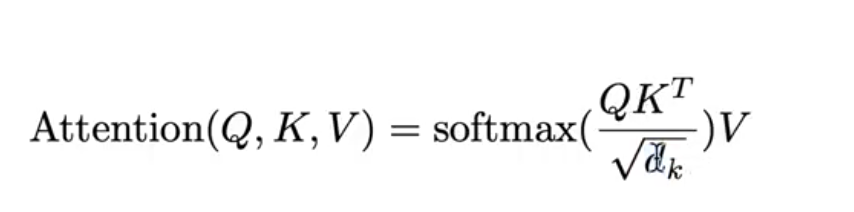

In [ ]:
#divide with root headsize
# to control the variance

In [67]:
B,T,head_size=2,4,16
k=torch.randn(B,T,head_size)
q=torch.randn(B,T,head_size)
wei=q@k.transpose(-2,-1)
print("q.var ",q.var())
print("k.var ",k.var())
print("wei.var ",wei.var())

q.var  tensor(1.1303)
k.var  tensor(0.9376)
wei.var  tensor(16.1297)


In [68]:
B,T,head_size=2,4,16
k=torch.randn(B,T,head_size)
q=torch.randn(B,T,head_size)
wei=q@k.transpose(-2,-1)*head_size**-0.5
print("q.var ",q.var())
print("k.var ",k.var())
print("wei.var ",wei.var())

q.var  tensor(0.9258)
k.var  tensor(1.0389)
wei.var  tensor(1.1272)


In [ ]:
torch.softmax(torch.tensor([0.1,-0.2,0.3,-0.2,0.5]),dim=-1)

tensor([0.1938, 0.1436, 0.2367, 0.1064, 0.3195])

In [77]:
torch.softmax(torch.tensor([0.1,-0.2,0.3,-0.2,0.5])*7,dim=-1)


tensor([0.0460, 0.0056, 0.1865, 0.0056, 0.7563])